# <div  style="color:#303030;font-family:'arial blACK', sans-serif,monospace; text-align: center; padding: 50px 0; vertical-align:middle;" > <img src="https://www.nicepng.com/png/full/204-2043038_white-lightbulb-icon-light-bulb-icon-white.png" style=" background:#00a0e4;border-radius:10px;width:150px;text-align:left; margin-left:10%"  /> <span style="position:relative; bottom:70px; margin-left:5%">Swimming</span> </div>

## <span style="color:#00a0e4;"> Keywords: </span>

```IMU data```, ```Data filtering```, ```Data segmentation```, ```Feature Extraction```

# I. Introduction
<br>
<div style="width:100%; background:#00a0e4;font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>


This notebook provides an example of the complete workflow from swimming data loading to its processing and feature extraction.

## <div style="color:#00a0e4;"> 1. Background</div>


Video-based and inertial sensing approaches (using wearable devices) are often used to support
swimmers and coaches in their daily work for improving performance and preventing injuries.

Inertial sensing approaches use waterproof inertial measurement units (IMUs) and have several
advantages. Firstly, there is no need to locate the markers in noisy images. Secondly, wearing a small
device causes less discomfort than a complete swimsuit with visual markers attached to it (or wearing
the markers on the skin). Thirdly, the IMUs can store large amounts of information and process parts
of it, so results can be readily accessed once transferred to a computer. Fourthly, IMUs enable
simultaneous assessment of many/all swimmers and are not limited to one at a time. Lastly, this is an
affordable solution, and every swimmer can easily access it. However, during competitions, setting
up swimmers with sensors is still not allowed, and their usage is therefore limited to only training
sessions.

In this session we will use one example file from the work "SwimBIT: A Novel Approach to Stroke Analysis
During Swim Training Based on Attitude and
Heading Reference System (AHRS)". It explored the use of an attitude and heading reference system (AHRS), which uses a
wearable device together with signal processing and machine learning workflows, for technical
gesture classification and computation of selected performance indicators. 

The hardware of the SwimBIT device includes an IMU with a 3-axis accelerometer, gyroscope, and magnetometer, allowing calculation of the absolute orientation of the module in space.
Data logging was done at 100 Hz, and the following parameters were recorded in comma-separated values (CSV) format: sampling time (ms), nine channels of the accelerometer (g), gyroscope (deg.s−1), magnetometer (gauss), and three Euler and heading angles (°).

This data comprises laps from the 4 main swimming styles: frontcrawl and backcrawl (non-symmetric styles) and breaststroke and butterfly (symmetric styles).

## <div style="color:#00a0e4;"> 2. Objectives
</div>

* enabling an overview of the most relevant steps that underly a real-world data processing application, for Swimming Data
* swimming data loading and pre-processing, using standard filtering
* data segmentation, to find the swimming laps
* laps segmentation, to find the strokes of each lap
* feature extraction within each stroke, based on the swimming style

# II. Experimental
<br>
<div style="width:100%; background:#00a0e4;font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>


## <div style="color:#00a0e4;">  1. Data Loading </div>

## <div style="color:#00a0e4;"> 1.1. Import libraries</div>

Firstly, we should install and import the useful packages for the next steps in our virtual machine. <br>
Note: the command ">/dev/null 2>&1" is only hiding the internal steps being taken.

In [1]:
%matplotlib notebook

!pip install biosppy >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install mpld3 >/dev/null 2>&1

In [3]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import os
from biosppy import plotting, utils
from biosppy.signals import tools
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import csv



And we can also select our plots preferences.

In [4]:
MAJOR_LW = 2.5
MINOR_LW = 1.5
MAX_ROWS = 10

## <div style="color:#00a0e4;"> 1.2. Load Example File</div>


To test this procedure, we will use an example file stored in this github repository.

In [6]:
url = 'https://raw.githubusercontent.com/PIA-Group/ScientIST-notebooks/master/X.Example_Files/1-LOG00141.csv'
data = pd.read_csv(url, names=['time','AXHJDB','Pitch', 'Roll', 'Yaw', 'Az', 'Ay', 'Ax','1','2','3B','4','5','6'])

sampling_rate=100.

## <div style="color:#00a0e4;"> 2. IMU data processing</div>


Next, we will process each of the relevant signals (Pitch, Roll, and Az), using standard filtering.

## <div style="color:#00a0e4;"> 2.1. Pitch signal filt</div>
</div>


## <div style="color:#00a0e4;"> 2.1.1. Filtering</div>


To filter the Pitch signal, we use a 48th-order Low-pass filter. 

In [8]:
filtered_pitch, _, _ = tools.filter_signal(signal=data['Pitch'],ftype='FIR',window='hamming',band='lowpass',order=48,
                                           frequency=3,sampling_rate=sampling_rate)

## <div style="color:#00a0e4;"> 2.1.2. Plotting </div>


<IPython.core.display.Javascript object>


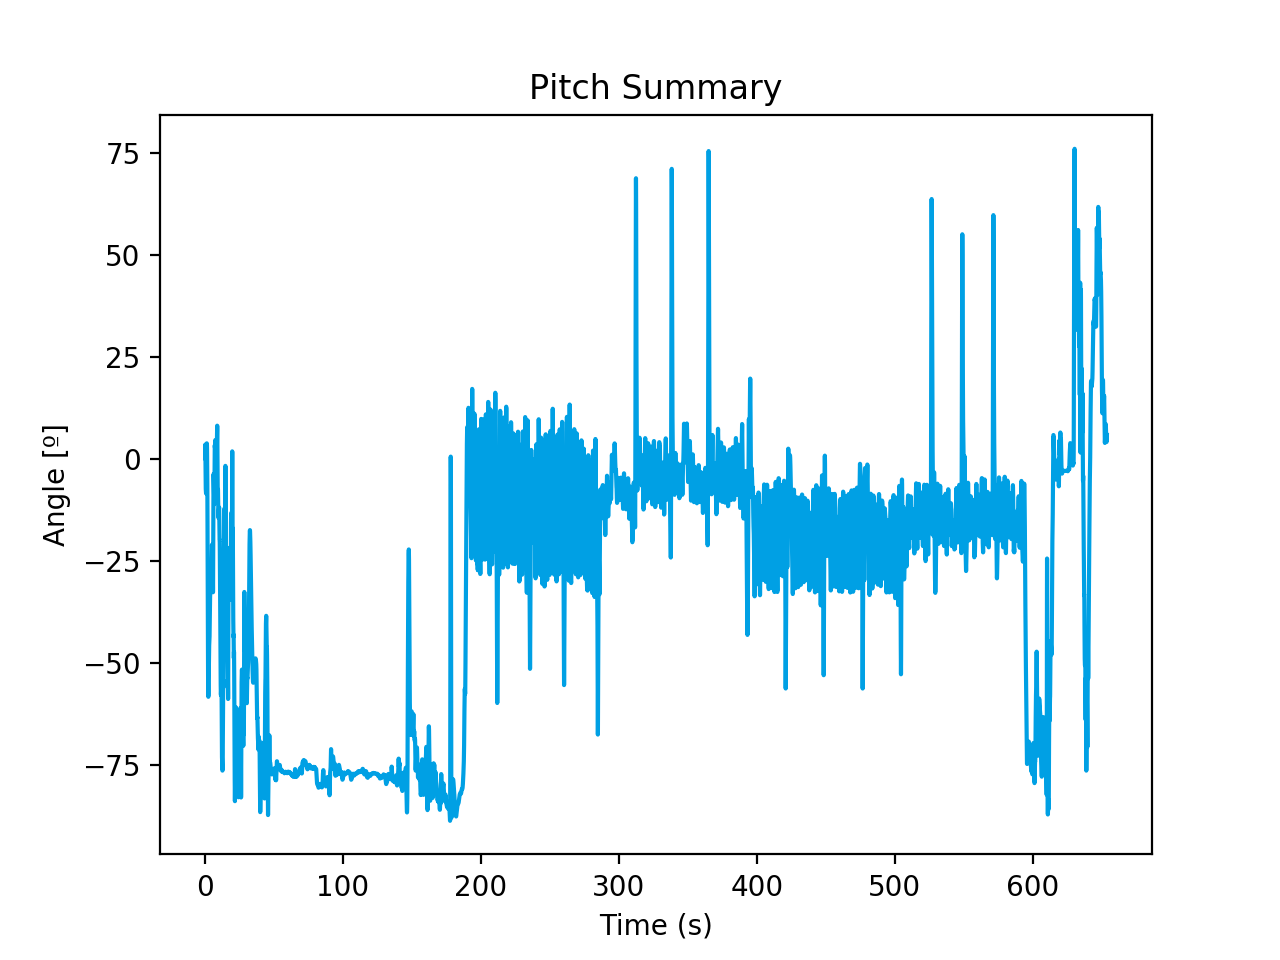

In [9]:
# get time vectors
length = len(data['Pitch'])
T = (length - 1) / sampling_rate
ts = np.linspace(0, T, length, endpoint=False)

# plot
plt.title('Pitch Summary')
plt.xlabel('Time (s)')
plt.ylabel('Angle [º]')
plt.plot(ts, filtered_pitch, color="#00a0e4")
plt.show()


## <div style="color:#00a0e4;"> 2.2.1. Filtering </div>


The same filtering is computed for the Roll signal, using a 48th-order Low-pass filter. 

In [9]:
filtered_roll, _, _ = tools.filter_signal(signal=data['Roll'],ftype='FIR',window='hamming',band='lowpass',order=48,
                                              frequency=3,sampling_rate=sampling_rate)

## <div style="color:#00a0e4;"> 2.2.2. Plotting </div>


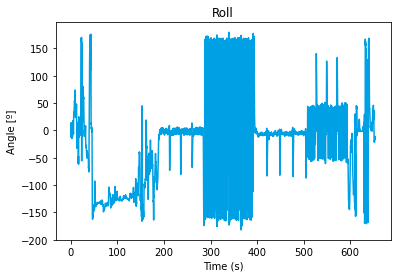

In [10]:
# get time vectors
length = len(data['Roll'])
T = (length - 1) / sampling_rate
ts = np.linspace(0, T, length, endpoint=False)

# plot
plt.title('Roll')
plt.xlabel('Time (s)')
plt.ylabel('Angle [º]')
plt.plot(ts, filtered_roll, color="#00a0e4")
plt.show()

## <div style="color:#00a0e4;"> 3. Swimming data processing</div>


## <div style="color:#00a0e4;"> 3.1. Pitch signal segmentation: Finding the swimming laps</div>


Swimming laps cand be segmented by identifying turns and stops.
<br>
As the swimmer is in an approximately horizontal position during the four
styles, the pitch angle can be analyzed to detect turns and stops. While swimming, the pitch typically
takes values lower than ±20°. When the swimmer makes a turn (either a tumble or an open turn), the pitch angle rises to a high value (close to ±90°). In a stop, the pitch angle changes from nearly 0° to −90° (when the swimmer is standing).
<br>
Thus, each segment will start at a peak (minimum or maximum) found in this signal.

In [11]:
signal=data['Pitch']

Min_idx_, Minima = find_peaks(-np.array(filtered_pitch),
                              distance=1200, height=39)
Max_idx_, Maxima = find_peaks(np.array(filtered_pitch), distance=1000, height=50)

segment_idx = np.sort(np.concatenate([np.ravel(Min_idx_), np.ravel(Max_idx_)]))

Then, considering the possibility of identifying outliers, we take the following step for exclusion of outlier segments.

In [12]:
idx = []
for s in range(1, len(segment_idx)):
    segment = filtered_pitch[segment_idx[s-1]:segment_idx[s]]
    mean = np.mean(segment)
    time_segm = segment_idx[s]-segment_idx[s-1]
    number = 0
    for item in segment[200:-200]:
        if item < 30 and item > -40:
            number += 1
    Percentage = number/len(segment)
    zero = 0
    for item in segment[200:-200]:
        if item > -15:
            zero += 1
    Percentage_zero = zero/len(segment)
    noise = 0
    for item in segment[200:-200]:
        if item < -50:
            noise += 1
    Percentage_noise = noise/len(segment)

    if mean > -40 and time_segm > 1000 and Percentage > 0.6 and Percentage_noise < 0.1 and Percentage_zero > 0.05:
        idx.append([segment_idx[s-1], segment_idx[s]])

segment_idx = idx
idx = np.ravel(idx)
idx = np.array(list(dict.fromkeys(idx)))

Finally, we summarize this processing in a plot. 
<br>
It will contain 3 subplots: 
* the raw and filtered signals; 
* the signal peaks identification along the filtered signal; 
* and overlapping of the segments (laps) identified.

In [5]:
# getting the time vectors
length = len(signal)
T = (length - 1) / sampling_rate
ts = np.linspace(0, T, length, endpoint=False)
mpld3.disable_notebook()

fig = plt.figure()
fig.suptitle('Pitch Summary')
gs = gridspec.GridSpec(6, 2)

# raw and filtered signal
ax1 = fig.add_subplot(gs[:3, 0])

ax1.plot(ts, signal, linewidth=MAJOR_LW, label='Raw signal', color="#c3c3c3")
ax1.plot(ts, filtered_pitch, linewidth=MAJOR_LW, label='Filtered',color="#00a0e4")
ax1.set_ylabel('Angle [º]')
ax1.set_xlabel('Time(s)')
ax1.legend()
ax1.grid()

# filtered signal with turns/stops
ax2 = fig.add_subplot(gs[3:6, 0], sharex=ax1)
ax2.plot(ts[segment_idx[0][0]:segment_idx[-1][1]], filtered_pitch[segment_idx[0][0]:segment_idx[-1][1]], linewidth=MAJOR_LW, label='Filtered')
ax2.scatter(idx/sampling_rate,
            filtered_pitch[idx], color='#00bfc2', linewidth=MINOR_LW, label='Turn or Stop')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle [º]')
ax2.legend()
ax2.grid()

# segments
ax3 = fig.add_subplot(gs[1:5, 1])
for i in range(0, len(segment_idx)):
    segment = filtered_pitch[segment_idx[i][0]:segment_idx[i][1]]
    length = len(segment)
    T = (length - 1) / sampling_rate
    ts = np.linspace(0, T, length, endpoint=False)
    ax3.plot(ts, segment, '#5756d6', linewidth=MINOR_LW, alpha=0.7)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude')
ax3.set_title('Segments')
ax3.grid()
plt.show()
#print(segment_idx)

NameError: name 'signal' is not defined

## <div style="color:#00a0e4;">3.2. Strokes segmentation</div>


Now that the laps were segmented, it matters to identify the swimming strokes within each of those laps. 
<br>
To do so, we must consider whether the lap we are analysing correponds to a symmetric ('Butterfly' or 'Breaststroke') or non-symmetric style ('Frontcrawl' or 'Backstroke'), as for the former the Pitch signal should be used, whilst for the latter the Roll signal should be used.

In [77]:
#Butterfly Example
butterfly_segment_pitch=filtered_pitch[segment_idx[0][0]:segment_idx[0][1]]
#Frontcrawl Example
frontcrawl_segment_pitch=filtered_pitch[segment_idx[6][0]:segment_idx[6][1]]
frontcrawl_segment_roll=filtered_roll[segment_idx[6][0]:segment_idx[6][1]]

## <div style="color:#00a0e4;"> 3.2.1. Symmetric Styles </div>


To segment the swimming strokes, we firstly identify the pitch signal peaks, using the function "find_peaks" that was imported at the beginning of this notebook.

In [87]:
signal = butterfly_segment_pitch
Min_idx, Minima = find_peaks(-signal, distance=150, height=2)
stroke_idx = []
for i in range(0, len(Min_idx)):
    if signal[Min_idx[i]] < 0:
        stroke_idx.append(Min_idx[i])
stroke_idx = np.array(stroke_idx)

Then, we can plot the resulting strokes.

Text(0.5, 1.0, 'Strokes')

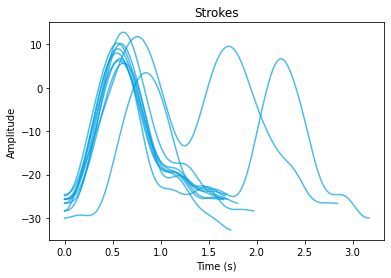

In [89]:
# get time vectors
length = len(signal)
T = (length - 1) / sampling_rate
ts = np.linspace(0, T, length, endpoint=False)

# strokes
for i in range(1, len(stroke_idx)):
    stroke = signal[stroke_idx[i-1]:stroke_idx[i]]
    length = len(stroke)
    T = (length - 1) / sampling_rate
    ts = np.linspace(0, T, length, endpoint=False)
    plt.plot(ts, stroke, 'm', color="#00a0e4",linewidth=MINOR_LW, label='Butterfly strokes', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Strokes')
plt.show()


## <div style="color:#00a0e4;"> 3.2.1. Non-symmetric Styles </div>


To segment the swimming strokes, we firstly identify the roll signal peaks.

In [81]:
signal=frontcrawl_segment_roll

Min_idx, Minima = find_peaks(-signal, distance=100, height=15)
Max_idx, Maxima = find_peaks(signal, distance=100, height=15)
stroke_idx = np.sort(np.concatenate(
    [np.ravel(Min_idx), np.ravel(Max_idx)]))
#print(stroke_idx)

[  26   70  249  349  469  570  679  764  890  996 1103 1212 1317 1424
 1533 1637 1749 1860 1971 2085 2188 2303 2424 2521 2590 2663 2774]


Then, we can plot the resulting strokes.

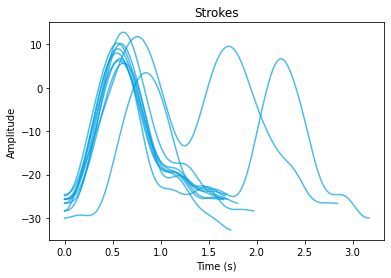

In [91]:
# get time vectors
length = len(signal)
T = (length - 1) / sampling_rate
ts = np.linspace(0, T, length, endpoint=False)

# strokes
for i in range(1, len(stroke_idx)):
    stroke = signal[stroke_idx[i-1]:stroke_idx[i]]
    length = len(stroke)
    T = (length - 1) / sampling_rate
    ts = np.linspace(0, T, length, endpoint=False)
    plt.plot(ts, stroke, 'm', color="#00a0e4",linewidth=MINOR_LW, label='Frontcrawl strokes', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Strokes')
plt.show()

## <div style="color:#00a0e4;">  3.3. Strokes statistics: extracting performance indicators of each lap</div>


Finally, we will compute the performance indicators from the indentified strokes within a lap:<br>
* time_lap : float<br>
    Duration time of the lap (seconds). <br>
* mean_velocity : float<br>
    Mean velocity registered in the lap (m/s). <br>
* nb_strokes : int<br>
    Number of strokes registered in the lap. <br>
* time_stroke : array<br>
    Duration time of each stroke in the lap (seconds). <br>
* mean_time_stroke : float<br>
    Mean duration time registered in the strokes of the lap (seconds). <br>
* rate_stroke : float<br>
    Mean number of strokes in the lap (strokes/min). <br>
* trunk_elevation : array<br>
    * For symmetrical styles (breaststroke and butterfly): difference between the minimum and maximum pitch angles within a stroke cycle. <br>
* body_balance : array<br>
    * For nonsymmetrical styles (front crawl and backstroke): average lap pitch. <br>
    * For symmetrical styles (breaststroke and butterfly): minimum and maximum pitch angles in each stroke cycle. <br>
* body_rotation : array<br>
    * For nonsymmetrical styles (front crawl and backstroke): minimum and maximum roll angles in each stroke cycle. <br>
    * For symmetrical styles (breaststroke and butterfly): average lap roll. <br>



In this case, to extract the performance indicators from the strokes of a swimming lap, we will implement the following function.

It receives 5 inputs: 
* segment_pitch (array, optional - if symmetric style ('Butterfly' or 'Breaststroke'));
* segment_roll (array, optional - if non-symmetric style ('Frontcrawl' or 'Backstroke'));
* style : (string - Swimming style ('Butterfly', 'Breaststroke', 'Frontcrawl' or 'Backstroke')


In [104]:
def statistics_strokes(segment_pitch=None, segment_roll=None, style=None):
   
    pool_distance=25
    
    if style in ['Butterfly', 'Breaststroke']:  # symmetric styles
        signal = segment_pitch
    elif style in ['Frontcrawl', 'Backstroke']:  # non-symmetric styles
        signal = segment_roll

    
    # identifying the strokes (as in the previous step)
    if style in ['Butterfly', 'Breaststroke']:
        Min_idx, Minima = find_peaks(-signal, distance=150, height=2)
        stroke_idx = []
        for i in range(0, len(Min_idx)):
            if signal[Min_idx[i]] < 0:
                stroke_idx.append(Min_idx[i])
        stroke_idx = np.array(stroke_idx)

    elif style in ['Frontcrawl', 'Backstroke']:
        Min_idx, Minima = find_peaks(-signal, distance=100, height=15)
        Max_idx, Maxima = find_peaks(signal, distance=100, height=15)
        stroke_idx = np.sort(np.concatenate([np.ravel(Min_idx), np.ravel(Max_idx)]))
        
    # compute the statistics
    time_lap = len(signal)/sampling_rate  # in seconds

    mean_velocity = pool_distance/time_lap  # in m/s

    nb_strokes = len(stroke_idx)-1

    time_stroke = []
    for i in range(1, len(stroke_idx)):
        time_stroke.append(
            len(signal[stroke_idx[i-1]:stroke_idx[i]])/sampling_rate)  # in seconds
    mean_time_stroke = np.mean(time_stroke)  # in seconds

    rate_stroke = 60*nb_strokes/time_lap  # in strokes/min

    trunk_elevation = []  # angle
    if style in ['Butterfly', 'Breaststroke']:
        for i in range(1, len(stroke_idx)):
            trunk_elevation.append(np.array(signal[stroke_idx[i-1]:stroke_idx[i]]).max(
            )-np.array(signal[stroke_idx[i-1]:stroke_idx[i]]).min())

    body_balance = []  # angle
    if style in ['Butterfly', 'Breaststroke']:
        for i in range(1, len(stroke_idx)):
            body_balance.append([np.array(signal[stroke_idx[i-1]:stroke_idx[i]]).min(
            ), np.array(signal[stroke_idx[i-1]:stroke_idx[i]]).max()])
    else:
        for i in range(1, len(stroke_idx)):
            body_balance.append(np.average(
                signal[stroke_idx[i-1]:stroke_idx[i]]))

    body_rotation = []  # angle
    if style in ['Butterfly', 'Breaststroke']:
        for i in range(1, len(stroke_idx)):
            body_rotation.append(np.average(
                segment_pitch[stroke_idx[i-1]:stroke_idx[i]]))
    else:
        for i in range(1, len(stroke_idx)):
            body_rotation.append([np.array(segment_roll[stroke_idx[i-1]:stroke_idx[i]]).min(
            ), np.array(segment_roll[stroke_idx[i-1]:stroke_idx[i]]).max()])
    
    print('time_lap:',time_lap)
    print('mean_velocity', mean_velocity)
    print('nb_strokes', nb_strokes)
    print('time_stroke', time_stroke)
    print('mean_time_stroke', mean_time_stroke)
    print('rate_stroke', rate_stroke)     
    print('trunk_elevation', trunk_elevation)
    print('body_balance', body_balance)
    print('body_rotation', body_rotation)

In [ ]:
statistics_strokes(segment_roll=frontcrawl_segment_roll,  style='Frontcrawl')

In [ ]:
statistics_strokes(segment_pitch=butterfly_segment_pitch,  style='Butterfly')

# III. Explore
<br>
<div style="width:100%; background:#00a0e4;font-family:'arial black',monospace; text-align: center; padding: 7px 0; border-radius: 5px 50px;margin-top:-15px" >  </div>


## <div style="color:#00a0e4;">  1. Final Notes </div>


The performance indicators used in this approach provide valuable
information for both swimmers and coaches in their quest for enhancing performance and
preventing injuries.


## <div style="color:#00a0e4;">  2. Further Reading </div>

1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6915422/
2. https://www.researchgate.net/publication/341541628_Development_of_a_Low-Cost_IMU_for_Swimmers'_Evaluation


<div style="height:115px; background:white;border-radius:10px;text-align:center"> 

<img src="https://www.lx.it.pt/~asmc/predict/images/IT.png" alt="it" style="position: relative; margin-left: 10px; bottom:-55px;max-width:150px;height:auto;"/> 
<img src="https://cqe.tecnico.ulisboa.pt/files/files/logos/IST_A_RGB_POS.png"
         alt="alternate text" 
         style="position: relative; margin-left: 10px;  bottom:-50px; width:150px;height:auto;"/>
</div> 

<div style="width: 100%; ">
<div style="background:#00a0e4;color:white;font-family:'arial', monospace; text-align: center; padding: 50px 0; border-radius:10px; height:10px; width:100%; float:left " >
<span style="font-size:12px;position:relative; top:-25px">  Please provide us your feedback <span style="font-size:14px;position:relative;COLOR:WHITE"> [here](https://forms.gle/C8TdLQUAS9r8BNJM8)</span>.</span> 
<br>
<span style="font-size:17px;position:relative; top:-20px">  Suggestions are welcome! </span> 
</div>

```Contributors: Joana Pinto```